# Пример реализации полносвязной нейросети на MNIST
---

In [1]:
import os
import sys

# For dlf package import
notebook_dir = os.path.split(os.getcwd())[0]
if notebook_dir not in sys.path:
    sys.path.append(notebook_dir)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Данные
Продемонстрирую работу своего мини-фрэймворка на классической  задачи распознавания рукописных цифр. Датасет состоит из пар X - изображение 28 на 28 пикселей со значениями яркости кажого пикселя от 0 до 1 и y - класс, изображённая цифра (0-9).

In [3]:
def loader(X, Y, batch_size):    
    n = X.shape[0]

    # перемешиваем индексы
    indices = np.arange(n)
    np.random.shuffle(indices)
    
    for start in range(0, n, batch_size):
        end = min(start + batch_size, n)
        batch_idx = indices[start:end]

        yield X[batch_idx], Y[batch_idx]

Скачиваем датасет.

In [4]:
import os
from sklearn.datasets import fetch_openml 

if os.path.exists('mnist.npz'):
    data = np.load("mnist.npz", allow_pickle=True)
    X = data['X']
    y = data['y']
else:
    mnist = fetch_openml("mnist_784")
    X = np.array(mnist.data / 255.0)
    y = np.array(mnist.target.astype(int))
    np.savez('mnist.npz', X=X, y=y)

In [5]:
def onehot(y):
    """Onehot encorder."""
    y_onehot = np.zeros(shape=(len(y), 10))
    y_onehot[np.arange(len(y)), y] = 1
    return y_onehot

def predict2class(predict):
    """Reverse operation to onehot."""
    return predict.argmax(axis=1)

assert (predict2class(onehot(y)) == y).all(), "Something go wrong with onehot encode/decode!"

Делим данные на обучающию и тестовую выборку в соотношение 4 к 1.

In [6]:
def train_test_split(X, y, test_size):
    train_end = int(np.ceil(len(X)*(1-test_size)))
    X_train, y_train = X[:train_end], y[:train_end]
    X_test, y_test = X[train_end:], y[train_end:]
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(X, onehot(y), .2)

### Логи

In [7]:
def _space_add(x, min_len=10):
    return " "*(min_len-len(x)) + x if len(x) < min_len else x

In [8]:
def print_log(accuracy_val, accuracy_train=None, spaces=10, **vec_metrics):
    columns = " "
    rows = [str(i) for i in range(10)]
    for metric_name, data in vec_metrics.items():
        columns += _space_add(metric_name, spaces)
        for i in range(10):
            rows[i] += _space_add("%.4f" % data[i], spaces)

    if len(rows[0]) > 1:
        print(columns)
        print("\n".join(rows) + "\n")
    if accuracy_train is not None:
        print("accuracy_train: %.4f" % accuracy_train)
    print("accuracy_val: %.4f" % accuracy_val)

In [9]:
def print_confusion_matrix(conf_m, classes, spaces=10):
    rows = [" " + "".join([_space_add(str(x), spaces) for x in range(10)]) + " true"]
    for i, cl in enumerate(classes):
        s = str(cl) + "".join([_space_add("%d" % x, spaces) for x in conf_m[i]]) 
        rows.append(s)
    print("\n".join(rows))
    print("pred")

## Обучение модели

In [10]:
from IPython.display import clear_output

In [11]:
# 0 - просто эпоха
# 1 - +accuracy_val
# 2 - +accuracy_train
# 3 - +f_score; +precision; +recall
VERBOSITY = 2
CLEAR_OUTPUT = False

learning_rate = 1e-3
batch_size = 128
epochs = 60

Создаём модель.

In [14]:
from dlf.linear import Linear
from dlf.activation import LeakyReLU
from dlf.base import Sequential
from dlf.penalty import Dropout, BatchNorm
from dlf.loss import CrossEntropy
from dlf.optim import NAdam

model = Sequential(
    Linear(784, 300),
    LeakyReLU(),
    Dropout(.4),
    BatchNorm(300),
    Linear(300, 300),
    LeakyReLU(),
    Dropout(.4),
    BatchNorm(300),
    Linear(300, 300),
    LeakyReLU(),
    Dropout(.4),
    BatchNorm(300),
    Linear(300, 10),
)

criterion = CrossEntropy()
optimizer = NAdam(learning_rate)

Обучаем модель и собираем статистику.

In [15]:
from dlf.utils import accuracy, precision, recall, f_score, confusion_matrix

history = {
    "train_loss":[], "val_loss":[], 
    "accuracy_train":[], "accuracy_val":[],
}

for epoch in range(1, epochs+1):
    # Train
    train_losses = []
    y_pred_l = []
    y_true_l = []
    for x, y in loader(X_train, y_train, batch_size=batch_size):
        y_pred = model(x)
        loss = criterion(y_pred, y)

        grad = criterion.backward(y_pred, y)
        model.backward(x, grad)
        
        optimizer(model.parameters(), model.grad_parameters())
        if VERBOSITY > 1:
            y_pred_l.append(y_pred)
            y_true_l.append(y)
        train_losses.append(loss)
    accuracy_train = accuracy(
        predict2class(np.vstack(y_pred_l)), predict2class(np.vstack(y_true_l))
    ) if VERBOSITY > 1 else None

    # Validation
    val_losses = []
    y_pred_l = []
    y_true_l = []
    model.eval()
    for x, y in loader(X_test, y_test, batch_size=batch_size):
        y_pred = model(x)
        loss = criterion(y_pred, y)
        if VERBOSITY > 0:
            y_pred_l.append(y_pred)
            y_true_l.append(y)
        val_losses.append(loss)
    model.train()

    # metrics
    if VERBOSITY > 0:
        y_pred= predict2class(np.vstack(y_pred_l))
        y_true = predict2class(np.vstack(y_true_l))
        accuracy_val = accuracy(y_pred, y_true)
        if VERBOSITY > 2:
            f1_score = f_score(y_pred, y_true)
            precision_score = precision(y_pred, y_true)
            recall_score = recall(y_pred, y_true)
    # history
    history["train_loss"].append(np.mean(np.hstack(train_losses)))
    history["val_loss"].append(np.mean(np.hstack(val_losses)))
    if VERBOSITY > 0:
        history["accuracy_val"].append(accuracy_val)
    if VERBOSITY > 1:
        history["accuracy_train"].append(accuracy_train)
    #
    metrics = dict(
        f1_score=f1_score, 
        precision=precision_score, 
        recall=recall_score
    ) if VERBOSITY > 2 else dict()
    print("epoch %d" % epoch)
    if VERBOSITY > 0:
        print_log(accuracy_val, accuracy_train, **metrics)
    if CLEAR_OUTPUT:
        clear_output(True)


epoch 1
accuracy_train: 0.8936
accuracy_val: 0.9639
epoch 2
accuracy_train: 0.9426
accuracy_val: 0.9722
epoch 3
accuracy_train: 0.9511
accuracy_val: 0.9755
epoch 4
accuracy_train: 0.9582
accuracy_val: 0.9746
epoch 5
accuracy_train: 0.9625
accuracy_val: 0.9790
epoch 6
accuracy_train: 0.9665
accuracy_val: 0.9790
epoch 7
accuracy_train: 0.9686
accuracy_val: 0.9806
epoch 8
accuracy_train: 0.9692
accuracy_val: 0.9814
epoch 9
accuracy_train: 0.9713
accuracy_val: 0.9813
epoch 10
accuracy_train: 0.9730
accuracy_val: 0.9808
epoch 11
accuracy_train: 0.9729
accuracy_val: 0.9822
epoch 12
accuracy_train: 0.9758
accuracy_val: 0.9829
epoch 13
accuracy_train: 0.9761
accuracy_val: 0.9821
epoch 14
accuracy_train: 0.9774
accuracy_val: 0.9817
epoch 15
accuracy_train: 0.9770
accuracy_val: 0.9836
epoch 16
accuracy_train: 0.9784
accuracy_val: 0.9831
epoch 17
accuracy_train: 0.9791
accuracy_val: 0.9835
epoch 18
accuracy_train: 0.9793
accuracy_val: 0.9831
epoch 19
accuracy_train: 0.9803
accuracy_val: 0.9824
ep

Выводим статистику.

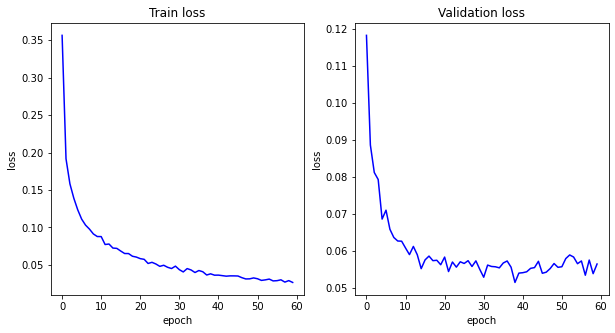

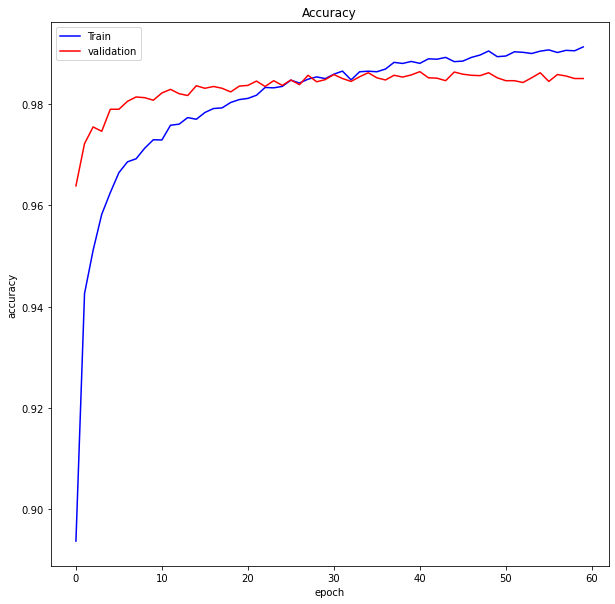

-------------------------------------------------- Confusion Matrix --------------------------------------------------
          0         1         2         3         4         5         6         7         8         9 true
0      1358         0         2         0         1         3         4         1         2         1
1         1      1557         1         0         2         0         2         4         3         3
2         2         1      1417         4         2         0         0         7         1         0
3         1         1         2      1396         0        14         1         2         7         6
4         1         0         1         0      1356         1         4         1         4        14
5         1         0         1         2         0      1221         2         0         5         7
6         3         4         0         0         3         9      1325         0         0         0
7         1         3         5         4         2         

In [16]:
def plot_loss(figsize=(10, 5)):
    _, (ax1, ax2) = plt.subplots(ncols=2, figsize=figsize)
    ax1.plot(history["train_loss"], c="blue")
    ax2.plot(history["val_loss"], c="blue")
    ax1.set_title('Train loss')
    ax2.set_title('Validation loss')
    for ax in ax1, ax2:
        ax.set_ylabel("loss")
        ax.set_xlabel("epoch")
    plt.show()
    
def plot_accuracy(figsize=(10, 10)):
    fig, ax = plt.subplots(figsize=figsize)
    if history.get("accuracy_train", False):
        ax.plot(history["accuracy_train"], c="blue", label="Train")
    ax.plot(history["accuracy_val"], c="red", label="validation")
    ax.set_title("Accuracy")
    ax.set_xlabel("epoch")
    ax.set_ylabel("accuracy")
    ax.legend()
    plt.show()

plot_loss()
plot_accuracy()
print("-"*50, "Confusion Matrix", "-"*50)
print_confusion_matrix(*confusion_matrix(y_pred, y_true))